# NoSQL (HBase) (sesión 6)

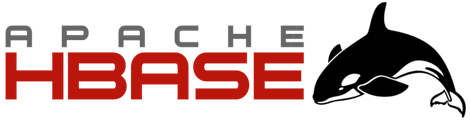

Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en el contenedor.

Con HBase vamos a simular un _clúster_ de varias máquinas con varios contenedores conectados. En el directorio `hbase` del repositorio git hay un script para ejecutar la instalación con `docker-compose`.

Para conectarse al _clúster_ con un _shell_ de hbase, hay que ejecutar, desde una terminal el siguiente comando de docker:

    $ docker exec -ti regionserver-1 hbase shell
    Base Shell; enter 'help<RETURN>' for list of supported commands.
    Type "exit<RETURN>" to leave the HBase Shell
    Version 1.2.7, rac57c51f7ad25e312b4275665d62b34a5945422f, Fri Sep  7 16:11:05 CDT 2018

    hbase(main):001:0> 


In [1]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [2]:
!pip install happybase

    100% |████████████████████████████████| 40kB 531kB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 659kB/s ta 0:00:01    63% |████████████████████▌           | 133kB 1.1MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 1.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for happybase ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/7a/d7/f7/447e781495238e394f04fe169f14549d31c63993e90152693b
  Running setup.py bdist_wheel for thriftpy ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/64/ff/0b/00a7ab5df78f8360908e34744eb78c2c537a327a295da5c260
Successfully built happybase thriftpy


In [3]:
import happybase

host = 'hbasethrift-1.vnet'
connection = happybase.Connection(host)
connection.tables()

[]

Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [4]:
%%bash
file=../Posts.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [5]:
%%bash
file=../Users.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [6]:
%%bash
file=../Tags.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [7]:
%%bash
file=../Comments.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [8]:
%%bash
file=../Votes.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [4]:
# Create tables
tables = ['posts', 'votes', 'users', 'tags', 'comments']
for t in tables:
    try:
        connection.create_table(
            t,
            {
                'rawdata': dict(max_versions=1,compression='GZ')
            })
    except:
        print("Database already exists: {0}.".format(t))
        pass
connection.tables()

[b'comments', b'posts', b'tags', b'users', b'votes']

El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [5]:
import csv

def csv_to_hbase(file, tablename, cf):
    table = connection.table(tablename)
    
    with open(file) as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')
        
        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        columns = [cf + ':' + c for c in columns]
        
        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns[1:], row[1:])))

In [6]:
for t in tables:
    print("Importando tabla {0}...".format(t))
    %time csv_to_hbase('../'+t.capitalize() + '.csv', t, 'rawdata')

Importando tabla posts...
CPU times: user 12.7 s, sys: 1.45 s, total: 14.1 s
Wall time: 52.5 s
Importando tabla votes...
CPU times: user 6.38 s, sys: 640 ms, total: 7.02 s
Wall time: 23.3 s
Importando tabla users...
CPU times: user 3.46 s, sys: 370 ms, total: 3.83 s
Wall time: 14.3 s
Importando tabla tags...
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 137 ms
Importando tabla comments...
CPU times: user 7.78 s, sys: 520 ms, total: 8.3 s
Wall time: 24.1 s


### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.

In [12]:
posts = connection.table('posts')

Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [13]:
posts.row(b'5',columns=[b'rawdata:Body'])

{b'rawdata:Body': b'<p>\xc2\xbfCu\xc3\xa1l es la forma m\xc3\xa1s eficiente de separar un string en <code>c++</code>? como el que se muestra en el c\xc3\xb3digo, el cual contiene espacios entre las palabras, este es el m\xc3\xa9todo que yo estoy usando actualmente.</p><br/><br/><pre><code>#include <iostream><br/>#include <sstream><br/><br/>int main(int argc, char** argv){<br/><br/>    std::string str("Texto para dividir");<br/>    std::istringstream isstream(str);<br/><br/>    while(!isstream.eof()){<br/><br/>        std::string tempStr;<br/><br/>        isstream >> tempStr;<br/><br/>        std::cout << tempStr << std::endl;<br/>    }<br/><br/>    return 0;<br/>}<br/></code></pre><br/>'}

El siguiente código permite mostrar de forma amigable las tablas extraídas de la base de datos en forma de diccionario:

In [14]:
# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        htmltext = ["<table width=100%>"]
        for key, value in self.items():
            htmltext.append("<tr>")
            htmltext.append("<td>{0}</td>".format(key.decode('utf-8')))
            htmltext.append("<td>{0}</td>".format(value.decode('utf-8')))
            htmltext.append("</tr>")
        htmltext.append("</table>")
        return ''.join(htmltext)

In [15]:
# Muestra cómo queda la fila del Id del Post 9997
DictTable(posts.row(b'5'))

rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6
rawdata:Body,"¿Cuál es la forma más eficiente de separar un string en c++? como el que se muestra en el código, el cual contiene espacios entre las palabras, este es el método que yo estoy usando actualmente.#include #include int main(int argc, char** argv){ std::string str(""Texto para dividir""); std::istringstream isstream(str); while(!isstream.eof()){ std::string tempStr; isstream >> tempStr; std::cout << tempStr << std::endl; } return 0;}"
rawdata:ClosedDate,
rawdata:CommentCount,1
rawdata:CommunityOwnedDate,
rawdata:CreationDate,2015-10-30T01:15:27.267
rawdata:FavoriteCount,
rawdata:LastActivityDate,2017-03-04T04:16:19.167
rawdata:LastEditDate,2016-09-27T17:46:24.900
rawdata:LastEditorDisplayName,


In [16]:
DictTable(posts.row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

rawdata:AcceptedAnswerId,208
rawdata:AnswerCount,6


Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [17]:
row = posts.row(b'5')
for key, value in row.items():
    print("Key = '%s', Value = '%s'" %(key,value.decode('utf-8')[:40]))

Key = 'b'rawdata:AcceptedAnswerId'', Value = '208'
Key = 'b'rawdata:AnswerCount'', Value = '6'
Key = 'b'rawdata:Body'', Value = '<p>¿Cuál es la forma más eficiente de se'
Key = 'b'rawdata:ClosedDate'', Value = ''
Key = 'b'rawdata:CommentCount'', Value = '1'
Key = 'b'rawdata:CommunityOwnedDate'', Value = ''
Key = 'b'rawdata:CreationDate'', Value = '2015-10-30T01:15:27.267'
Key = 'b'rawdata:FavoriteCount'', Value = ''
Key = 'b'rawdata:LastActivityDate'', Value = '2017-03-04T04:16:19.167'
Key = 'b'rawdata:LastEditDate'', Value = '2016-09-27T17:46:24.900'
Key = 'b'rawdata:LastEditorDisplayName'', Value = ''
Key = 'b'rawdata:LastEditorUserId'', Value = '729'
Key = 'b'rawdata:OwnerDisplayName'', Value = ''
Key = 'b'rawdata:OwnerUserId'', Value = '24'
Key = 'b'rawdata:ParentId'', Value = ''
Key = 'b'rawdata:PostTypeId'', Value = '1'
Key = 'b'rawdata:Score'', Value = '19'
Key = 'b'rawdata:Tags'', Value = '<c++><string>'
Key = 'b'rawdata:Title'', Value = '¿Cómo separar las palabras que contiene

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [18]:
max_len = 0
for key, data in posts.scan():
    cur_len = len(data[b'rawdata:Body'].decode('utf-8'))
    if cur_len > max_len:
        max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

Máxima longitud: 38134 caracteres.


### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas.

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`". La base de datos permite implementar filtros que nos permiten buscar esto de forma muy sencilla. Los veremos después.

In [21]:
connection = happybase.Connection(host)

comments = connection.table('comments')
posts = connection.table('posts')

with posts.batch(batch_size=500) as bp:
    # Hacer un scan de la tabla
    for key, data in comments.scan():
        comment = {'comments:' +
                   d.decode('utf-8').split(':')[1] + "_" +
                   key.decode('utf-8') : 
                   data[d].decode('utf-8') for d in data.keys()}
        bp.put(data[b'rawdata:PostId'], comment)

In [22]:
%%bash
file=../eswiki.xml
test -e $file || wget http://neuromancer.inf.um.es:8080/wikipedia/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [23]:
!head -200 ../eswiki.xml

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="es">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <dbname>eswiki</dbname>
    <base>https://es.wikipedia.org/wiki/Wikipedia:Portada</base>
    <generator>MediaWiki 1.28.0-wmf.22</generator>
    <case>first-letter</case>
    <namespaces>
      <namespace key="-2" case="first-letter">Medio</namespace>
      <namespace key="-1" case="first-letter">Especial</namespace>
      <namespace key="0" case="first-letter" />
      <namespace key="1" case="first-letter">Discusión</namespace>
      <namespace key="2" case="first-letter">Usuario</namespace>
      <namespace key="3" case="first-letter">Usuario discusión</namespace>
      <namespace key="4" case="first-letter">Wikipedia</namespace>
      <namespace key="5" case="first-letter">Wikipedia 

Se crea la tabla para albergar la `wikipedia`. Igual que la vista en teoría, pero aquí se usa `wikipedia` en vez de `wiki` para que no colisionen la versión completa con la reducida.

De nuevo en el `shell` de HBase:

```
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia' 
```

Este código, visto en teoría, recorre el árbol XML construyendo documentos y llamando a la función `callback` con cada uno. Los documentos son diccionarios con las claves encontradas dentro de los tags `<page>...</page>`.

In [24]:
import xml.sax
import re

class WikiHandler(xml.sax.handler.ContentHandler):

    def __init__(self):
        self._charBuffer = ''
        self.document = {}

    def _getCharacterData(self):
        data = self._charBuffer
        self._charBuffer = ''
        return data

    def parse(self, f, callback):
        self.callback = callback
        xml.sax.parse(f, self)

    def characters(self, data):
        self._charBuffer = self._charBuffer + data

    def startElement(self, name, attrs):
        if name == 'page':
        # print 'Start of page'
            self.document = {}
        if re.match(r'title|timestamp|username|comment|text', name):
            self._charBuffer = ''

    def endElement(self, name):
        if re.match(r'title|timestamp|username|comment|text', name):
            self.document[name] = self._getCharacterData()
            # print(name, ': ', self.document[name][:20])
        if 'revision' == name:
            self.callback(self.document)


El codigo a continuación, cada vez que el código anterior llama a la función `processdoc()` se añade un documento a la base de datos.

In [25]:
import time

class FillWikiTable():
    """Llena la tabla Wiki"""
    def __init__(self):
        # Conectar a la base de datos a través de Thrift
        self.table = connection.table('wikipedia')

    def run(_s):
        def processdoc(d):
            print("Callback called with {0}".format(d['title']))
            tuple_time = time.strptime(d['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            timestamp = int(time.mktime(tuple_time))
            _s.table.put(d['title'],
                         {'text:': d.get('text',''),
                          'revision:author': d.get('username',''),
                          'revision:comment': d.get('comment','')},
                         timestamp=timestamp)

        with open('../eswiki.xml','r') as f:
            start = time.time()
            WikiHandler().parse(f, processdoc)
            end = time.time()
            print ("End adding documents. Time: %.5f" % (end - start))

In [26]:
connection = happybase.Connection(host)

FillWikiTable().run()

Callback called with Wikipedia:Artículos solicitados
Callback called with Andorra
Callback called with Argentina
Callback called with Geografía de Andorra
Callback called with Demografía de Andorra
Callback called with Comunicaciones de Andorra
Callback called with Artes visuales
Callback called with Agricultura
Callback called with Astronomía galáctica
Callback called with ASCII
Callback called with Arquitectura
Callback called with Anoeta
Callback called with Ana María Matute
Callback called with Agujero negro
Callback called with Anarquía
Callback called with América del Norte
Callback called with América del Sur
Callback called with Asia
Callback called with Año
Callback called with Asaph Hall
Callback called with Afganistán
Callback called with Arqueología
Callback called with Wikipedia:Anuncios
Callback called with Commodore Amiga
Callback called with Commodore Amiga 500
Callback called with Francesc Aguilar Villalonga
Callback called with Aquifoliaceae
Callback called with Sapin

Callback called with Barcelona
Callback called with BIOS
Callback called with Barrapunto
Callback called with Bougainvillea
Callback called with Basílica de San Isidoro de León
Callback called with Biblia
Callback called with Biología molecular
Callback called with Biblioteca
Callback called with Casco Antiguo de León
Callback called with Brasil
Callback called with Evangelio de Lucas
Callback called with Beethoven
Callback called with Vergara
Callback called with Bomba hidráulica
Callback called with Bandera
Callback called with Bellerophon
Callback called with Bodhisattva
Callback called with Billy Wilder
Callback called with Buda
Callback called with Bolero ranchero
Callback called with Bacteria
Callback called with Burramyidae
Callback called with Ayuda:Cómo se edita una página
Callback called with Ayuda:Cómo empezar una página
Callback called with Wikipedia:Cómo Debe Llamarse La HomePage
Callback called with Constelación
Callback called with Cristalografia
Callback called with Cal

Callback called with Comunidad autónoma
Callback called with Cartografía
Callback called with Compositor
Callback called with Cultura
Callback called with Ciencias aplicadas
Callback called with Clasificación (desambiguación)
Callback called with Clase
Callback called with Clasificación Unesco
Callback called with Clasificación Unesco de 4 dígitos
Callback called with Camino de Santiago
Callback called with Clasificación Unesco de 6 dígitos
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/11 Lógica
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/12 Matemática
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/21 Astronomía y Astrofísica
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/22 Física
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/23 Química
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/24 Ciencias de la Vida
Callback called with Wikipedia:Clasificación Unesco de 6 dígitos/25 C

Callback called with Esperanto
Callback called with Efecto túnel
Callback called with Equisetidae
Callback called with Idioma español
Callback called with Enero
Callback called with Entretenimiento
Callback called with Ecósfera
Callback called with Euglena
Callback called with Erytropsis
Callback called with Equipo terminal de datos
Callback called with ETCD
Callback called with Equidistante
Callback called with Euryarchaeota
Callback called with Echinochloa
Callback called with Elymus
Callback called with Eragrostis
Callback called with Esfera
Callback called with Etimología
Callback called with Esmeralda
Callback called with Eatonia
Callback called with Ekmanochloa
Callback called with Eleusine
Callback called with Elionurus
Callback called with Elymordeum montanense
Callback called with Elyonurus
Callback called with Enteropogon
Callback called with Epicampes
Callback called with Eremochloa
Callback called with Eriachne
Callback called with Erianthus
Callback called with Eriochloa
C

El código a continuación permite ver las diferentes versiones de una revisión. Como la versión reducida es muy pequeña no da lugar a que haya ninguna revisión, pero con este código se vería. Hace uso del _shell_ de HBase:

    get 'wikipedia', 'Commodore Amiga', {COLUMN => 'revision',VERSIONS=>10}

In [27]:
connection = happybase.Connection(host)

wikipedia = connection.table('wikipedia')

In [28]:
for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='B', limit=10):
    print(key,'->',data)

b'A fala' -> {b'revision:author': b'KLBot2', b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'AGA' -> {b'revision:author': b'Savh', b'revision:comment': b'Savh movi\xc3\xb3 la p\xc3\xa1gina [[AGA (desambiguaci\xc3\xb3n)]] a [[AGA]]: Solicitado'}
b'ALGOL' -> {b'revision:author': b'G\xc3\xbcnniX', b'revision:comment': b'/* Enlaces externos y bibliograf\xc3\xada */'}
b'ASCII' -> {b'revision:author': b'', b'revision:comment': b''}
b'Abreviatura' -> {b'revision:author': b'', b'revision:comment': b'/* Diccionarios de abreviaturas */'}
b'Acacia' -> {b'revision:author': b'Jkbw', b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/212.55.25.241|212.55.25.241]] ([[User talk:212.55.25.241|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Jkbw'}
b'Acamptoclados' -> {b'revision:author': b'KLBot2', b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'Acarreo' -> {b'revision:author': b'Farisori', b'revision:comment': b'Revertidos lo

La siguiente consulta no poduce resultados. ¿Por qué?

In [29]:
for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='C',
                               filter="PrefixFilter('B')",
                               limit=10):
    print (key,'->',data)

b'BASIC' -> {b'revision:author': b'Benjavalero', b'revision:comment': b'Correcciones ortogr\xc3\xa1ficas'}
b'BIOS' -> {b'revision:author': b'PatruBOT', b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/79.153.162.34|79.153.162.34]] ([[User talk:79.153.162.34|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Mansoncc'}
b'Bacteria' -> {b'revision:author': b'Technopat', b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/181.57.143.98|181.57.143.98]] ([[User talk:181.57.143.98|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Osado'}
b'Balanophoraceae' -> {b'revision:author': b'', b'revision:comment': b''}
b'Baloncesto' -> {b'revision:author': b'Balles2601', b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/64.32.117.118|64.32.117.118]] ([[User talk:64.32.117.118|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Wiki LIC'}
b'Balsaminaceae' -> {b'revision:author': b'Elvisor', b'revision:comment': b'Bot:Reparando enlaces'}
b'Bambuseae' 

En los siguientes ejercicios, usando `happybase`, utiliza o bien `scan` o bien `row` donde sea conveniente:

## EJERCICIO: Mostrar la familia de columnas `revision` para la entrada `ASCII` de la tabla `wikipedia`.

In [30]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

wikipedia.row(b'ASCII', columns=[b'revision'])

{b'revision:author': b'', b'revision:comment': b''}

## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com'.

In [31]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(filter="ColumnPrefixFilter('com')",
                               limit=20):
    print (key,'->',data)

b'A fala' -> {b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'AGA' -> {b'revision:comment': b'Savh movi\xc3\xb3 la p\xc3\xa1gina [[AGA (desambiguaci\xc3\xb3n)]] a [[AGA]]: Solicitado'}
b'ALGOL' -> {b'revision:comment': b'/* Enlaces externos y bibliograf\xc3\xada */'}
b'ASCII' -> {b'revision:comment': b''}
b'Abreviatura' -> {b'revision:comment': b'/* Diccionarios de abreviaturas */'}
b'Acacia' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/212.55.25.241|212.55.25.241]] ([[User talk:212.55.25.241|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Jkbw'}
b'Acamptoclados' -> {b'revision:comment': b'Bot: Cambiando #REDIRECT por #REDIRECCI\xc3\x93N.'}
b'Acarreo' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/~Expresses life|~Expresses life]] ([[User talk:~Expresses life|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Farisori'}
b'Acento l\xc3\xa9xico' -> {b'revision:comment': b'Peque\xc3\xb1as correcciones [[WP

## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com' y la clave de fila empieza por 'B'.

In [32]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(filter="ColumnPrefixFilter('com') AND PrefixFilter('B')",
                               limit=20):
    print (key,'->',data)

b'BASIC' -> {b'revision:comment': b'Correcciones ortogr\xc3\xa1ficas'}
b'BIOS' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/79.153.162.34|79.153.162.34]] ([[User talk:79.153.162.34|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Mansoncc'}
b'Bacteria' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/181.57.143.98|181.57.143.98]] ([[User talk:181.57.143.98|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Osado'}
b'Balanophoraceae' -> {b'revision:comment': b''}
b'Baloncesto' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/64.32.117.118|64.32.117.118]] ([[User talk:64.32.117.118|disc.]]) a la \xc3\xbaltima edici\xc3\xb3n de Wiki LIC'}
b'Balsaminaceae' -> {b'revision:comment': b'Bot:Reparando enlaces'}
b'Bambuseae' -> {b'revision:comment': b''}
b'Bandera' -> {b'revision:comment': b'Revertidos los cambios de [[Special:Contributions/Mariiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii|Mar

## EJERCICIO: Mostrar sólo la columna `revision:author` de las filas de la tabla `wikipedia` cuya clave empiece por `a` y termine por `a` (obviando mayúsculas y minúsculas).

In [33]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(columns=[b'revision:author'],
                              filter="RowFilter(=, 'regexstring:^[Aa].*[Aa]$')"):
    print (key,'->',data)

b'A fala' -> {b'revision:author': b'KLBot2'}
b'AGA' -> {b'revision:author': b'Savh'}
b'Abreviatura' -> {b'revision:author': b''}
b'Acacia' -> {b'revision:author': b'Jkbw'}
b'Achlaena' -> {b'revision:author': b'KLBot2'}
b'Achneria' -> {b'revision:author': b'MILEPRI'}
b'Actual rey de Francia' -> {b'revision:author': b'CEM-bot'}
b'Ada' -> {b'revision:author': b'Solbaken'}
b'Adventista' -> {b'revision:author': b'Benjavalero'}
b'Afrodita' -> {b'revision:author': b'Foundling'}
b'Agricultura' -> {b'revision:author': b'Foundling'}
b'Agricultura ecol\xc3\xb3gica' -> {b'revision:author': b'Lin linao'}
b'Aira' -> {b'revision:author': b'BenjaBot'}
b'Airopsis tenella' -> {b'revision:author': b'BenjaBot'}
b'Ala' -> {b'revision:author': b'Shooke'}
b'Albania' -> {b'revision:author': b''}
b'Alberta' -> {b'revision:author': b'Alexandra Desir\xc3\xa9e Reyes'}
b'Aldea' -> {b'revision:author': b'4lextintor'}
b'Alegor\xc3\xada' -> {b'revision:author': b'Arjuno3'}
b'Alemania' -> {b'revision:author': b'Arjuno

## EJERCICIO: Mostrar las filas de la tabla `wikipedia` cuya clave contenga al menos un número.

In [34]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(columns=[b'revision:author'],
                              filter="RowFilter(=, 'regexstring:[0-9]')"):
    print (key,'->',data)

b'A\xc3\xb1o 1900' -> {b'revision:author': b'Bark~eswiki'}
b'Clasificaci\xc3\xb3n Unesco de 4 d\xc3\xadgitos' -> {b'revision:author': b'Arjuno3'}
b'Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos' -> {b'revision:author': b'Legobot'}
b'Commodore 128' -> {b'revision:author': b'Benjavalero'}
b'Commodore 64' -> {b'revision:author': b''}
b'Commodore Amiga 500' -> {b'revision:author': b''}
b'Constituci\xc3\xb3n de 1812' -> {b'revision:author': b'ManuelGR'}
b'C\xc3\xb3digo de caracteres de 8 bits' -> {b'revision:author': b'Marcomogollon'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/11 L\xc3\xb3gica' -> {b'revision:author': b''}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/12 Matem\xc3\xa1tica' -> {b'revision:author': b'UA31'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/21 Astronom\xc3\xada y Astrof\xc3\xadsica' -> {b'revision:author': b'Addbot'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/22 F\xc3\xadsica' -> {b'revision:author': 

## EJERCICIO: Mostrar las filas de la tabla `wikipedia` cuyo autor de revisión sea `Addbot`.

In [35]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(columns=[b'revision:author'],
                              filter="SingleColumnValueFilter('revision', 'author', =, 'binary:Addbot')"):
    print (key,'->',data)

b'Discolichenes' -> {b'revision:author': b'Addbot'}
b'Euchlaena' -> {b'revision:author': b'Addbot'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/21 Astronom\xc3\xada y Astrof\xc3\xadsica' -> {b'revision:author': b'Addbot'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/24 Ciencias de la Vida' -> {b'revision:author': b'Addbot'}
b'Wikipedia:Clasificaci\xc3\xb3n Unesco de 6 d\xc3\xadgitos/32 Ciencias M\xc3\xa9dicas' -> {b'revision:author': b'Addbot'}


## EJERCICIO: Mostrar las filas de la tabla `wikipedia` tales que alguno de sus valores de campos de columnas sea menor que 1.

In [36]:
connection = happybase.Connection(host)
wikipedia = connection.table('wikipedia')

for key,data in wikipedia.scan(columns=[b'revision:author'],
                              filter="ValueFilter(<, 'binary:1')"):
    print (key,'->',data)

b'ASCII' -> {b'revision:author': b''}
b'Abreviatura' -> {b'revision:author': b''}
b'Acr\xc3\xb3stico' -> {b'revision:author': b''}
b'Agujero negro de Schwarzschild' -> {b'revision:author': b''}
b'Albania' -> {b'revision:author': b''}
b'Alcaloide' -> {b'revision:author': b''}
b'Algoritmo' -> {b'revision:author': b''}
b'Algoritmo gen\xc3\xa9tico' -> {b'revision:author': b''}
b'Ampelodesmos' -> {b'revision:author': b''}
b'Anarqu\xc3\xada' -> {b'revision:author': b''}
b'Anexo:Calendario de aniversarios' -> {b'revision:author': b''}
b'Anexo:Diferencias de l\xc3\xa9xico entre pa\xc3\xadses de lengua espa\xc3\xb1ola' -> {b'revision:author': b''}
b'Antigua y Barbuda' -> {b'revision:author': b''}
b'Antipart\xc3\xadcula' -> {b'revision:author': b''}
b'Apoclada simplex' -> {b'revision:author': b''}
b'Aromadendron' -> {b'revision:author': b''}
b'Astronom\xc3\xada gal\xc3\xa1ctica' -> {b'revision:author': b''}
b'Atlante' -> {b'revision:author': b''}
b'Atlas (desambiguaci\xc3\xb3n)' -> {b'revision:a

## EJERCICIO: Mostrar las filas de la tabla `users` (sólo la columna `rawdata:Location`) de usuarios de España (se supondrá que su localización (columna `rawdata:Location`) contiene `España` o `ES`, obviando mayúsculas y minúsculas).

In [37]:
connection = happybase.Connection(host)
users = connection.table('users')

for key,data in users.scan(columns=[b'rawdata:Location'],
                              filter="SingleColumnValueFilter('rawdata', 'Location', =, 'regexstring:(\W|^)[Ee][Ss]([Pp][Aa][Ññ][Aa])?(\W|$)')"):
    print (key,'->',data)

b'10136' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10335' -> {b'rawdata:Location': b'Matar\xc3\xb3, Espa\xc3\xb1a'}
b'10429' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'10497' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'10576' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'10692' -> {b'rawdata:Location': b'Sevilla, Espa\xc3\xb1a'}
b'10796' -> {b'rawdata:Location': b'Zaragoza, Espa\xc3\xb1a'}
b'10848' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10862' -> {b'rawdata:Location': b'Santiago de Compostela, Espa\xc3\xb1a'}
b'10895' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'10915' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'11045' -> {b'rawdata:Location': b'Archena, Murcia, Espa\xc3\xb1a'}
b'11114' -> {b'rawdata:Location': b'Las Rozas, Espa\xc3\xb1a'}
b'11125' -> {b'rawdata:Location': b'Palencia, Espa\xc3\xb1a'}
b'11132' -> {b'rawdata:Location': b'Lleida, Catalu\xc3\xb1a, Espa\xc3\xb1a'}
b'11160' -> {b'rawdata:Location': 

b'25728' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'25800' -> {b'rawdata:Location': b'Espa\xc3\xb1a'}
b'25897' -> {b'rawdata:Location': b'Sevilla, Espa\xc3\xb1a'}
b'25950' -> {b'rawdata:Location': b'San Sebasti\xc3\xa1n, Espa\xc3\xb1a'}
b'26024' -> {b'rawdata:Location': b'Castelldefels, Espa\xc3\xb1a'}
b'26041' -> {b'rawdata:Location': b'Getafe, Espa\xc3\xb1a'}
b'26049' -> {b'rawdata:Location': b'Vigo, Espa\xc3\xb1a'}
b'26053' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26059' -> {b'rawdata:Location': b'Albacete, Espa\xc3\xb1a'}
b'26081' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26097' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26102' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26132' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'26164' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26165' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'26175' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'26195' -> {b'rawdat

b'36029' -> {b'rawdata:Location': b'Murcia, Espa\xc3\xb1a'}
b'3603' -> {b'rawdata:Location': b'Valencia, Espa\xc3\xb1a'}
b'36041' -> {b'rawdata:Location': b'Sevilla, Espa\xc3\xb1a'}
b'3610' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'36170' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'36178' -> {b'rawdata:Location': b'Espa\xc3\xb1a'}
b'3644' -> {b'rawdata:Location': b'Granada, Espa\xc3\xb1a'}
b'3654' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'3695' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'3719' -> {b'rawdata:Location': b'Algeciras, Espa\xc3\xb1a'}
b'3720' -> {b'rawdata:Location': b'Tarragona, Espa\xc3\xb1a'}
b'37248' -> {b'rawdata:Location': b'And\xc3\xbajar, Ja\xc3\xa9n, Espa\xc3\xb1a'}
b'37283' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'3729' -> {b'rawdata:Location': b'Espa\xc3\xb1a'}
b'37387' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'37436' -> {b'rawdata:Location': b'Le\xc3\xb3n, Espa\xc3\xb1a'}
b'37488' -> {b'rawdata:Lo

b'4986' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'49901' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'49903' -> {b'rawdata:Location': b'Campo de Criptana, Ciudad Real, Espa\xc3\xb1a'}
b'49983' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'50057' -> {b'rawdata:Location': b'Ir\xc3\xban, Guip\xc3\xbazcoa, Espa\xc3\xb1a'}
b'50191' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'50192' -> {b'rawdata:Location': b'Sevilla, Espa\xc3\xb1a'}
b'50207' -> {b'rawdata:Location': b'M\xc3\xa1laga, Espa\xc3\xb1a'}
b'50329' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'50361' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'50392' -> {b'rawdata:Location': b'Algeciras, C\xc3\xa1diz, Espa\xc3\xb1a'}
b'50396' -> {b'rawdata:Location': b'Lloret de Mar, Espa\xc3\xb1a'}
b'50493' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'50545' -> {b'rawdata:Location': b'Barcelona, Espa\xc3\xb1a'}
b'50622' -> {b'rawdata:Location': b'Madrid, Espa\xc3\xb1a'}
b'50717' -

## EJERCICIO: Comparar si hay más usuarios de Santiago de Compostela que de Murcia :).

In [38]:
connection = happybase.Connection(host)
users = connection.table('users')

murcia = users.scan(columns=[b'rawdata:Location'],
                              filter="SingleColumnValueFilter('rawdata', 'Location', =, 'regexstring:[Mm][Uu][Rr][Cc][Ii][Aa]')")

santiago = users.scan(columns=[b'rawdata:Location'],
                              filter="SingleColumnValueFilter('rawdata', 'Location', =, 'regexstring:[Ss][Aa][Nn][Tt][Ii][Aa][Gg][Oo] [Dd][Ee] [Cc][Oo][Mm][Pp][Oo][Ss][Tt][Ee][Ll][Aa]')")

print("Usuarios en Murcia: {}".format(len(list(murcia))))
print("Usuarios en Santiago de Compostela: {}".format(len(list(santiago))))

Usuarios en Murcia: 43
Usuarios en Santiago de Compostela: 12


## EJERCICIO: Mostrar las filas de la tabla `posts` que hacen referencia al tag "clojure".

In [39]:
connection = happybase.Connection(host)
posts = connection.table('posts')

for key,data in posts.scan(columns=[b'rawdata:Tags'],
                        filter="SingleColumnValueFilter('rawdata', 'Tags', =, 'regexstring:<clojure>')"):
    print (key,'->',data)


b'1422' -> {b'rawdata:Tags': b'<clojure>'}


## EJERCICIO (opcional): Crear una nueva tabla `poststags` que, de forma eficiente, para cada _tag_, liste los `Id` de los posts que utilizan ese _tag_.

*Nota: El código de ejemplo para separar todas las etiquetas del campo Tags de un post está en la sesión 1.*

Creamos una tabla *poststags* con una familia de columnas *posts*.

In [7]:
connection = happybase.Connection(host)
connection.create_table(name="poststags", 
                        families={
                            'posts': dict(max_versions=1)
                        })

Extraemos los datos de los tags de la tabla *posts*, los procesamos y creamos las entradas de la tabla *poststags*.

Como clave de fila utilizamos el nombre del tag y utilizamos una columna dentro de la columna de familias para guardar el id de cada post. Como valor en esa columna guardamos el conjunto de tags utilizados en ese post. Esto puede permitir conocer qué tags están relacionados con el original.

In [8]:
connection = happybase.Connection(host)
posts = connection.table('posts')
poststags = connection.table('poststags')

# Rellenar tabla PostTags
import re

# Obtener los datos iniciales de los Tags
results = posts.scan(columns=[b'rawdata:Tags'])

for key, value in results:
    postId = key.decode('utf-8')
    tags = value[b'rawdata:Tags'].decode('utf-8')
    tagsSplit = re.findall('<(.*?)>', tags)
    for tag in tagsSplit:
        poststags.put(tag,
                     {'posts:{}'.format(postId): tags})


Podemos obtener rápidamente los posts que tienen el tag *clojure*. Como vemos, sólo aparece el post 1422, al igual que en el ejercicio anterior.

In [9]:
connection = happybase.Connection(host)
poststags = connection.table('poststags')

results = poststags.row('clojure')

for post in results:
    print(post.decode('utf-8'), results[post].decode('utf-8'))



posts:1422 <clojure>


Podemos comprobar mejor su correcto funcionamiento con tags más populares como *postgresql*.

In [10]:
connection = happybase.Connection(host)
poststags = connection.table('poststags')

results = poststags.row('postgresql')

for post in results:
    print(post.decode('utf-8'), results[post].decode('utf-8'))


posts:10371 <python><django><postgresql>
posts:10389 <python><django><postgresql><djangorestframework>
posts:1071 <django><sql><postgresql>
posts:10716 <python><django><postgresql><djangorestframework>
posts:10856 <python><django><postgresql>
posts:11073 <python><django><postgresql><djangorestframework>
posts:11087 <sql><postgresql>
posts:11159 <sql><postgresql>
posts:11478 <java><sql><postgresql><jpa><glassfish>
posts:11568 <sql><postgresql>
posts:1291 <java><postgresql>
posts:13550 <postgresql>
posts:14118 <php><sql><postgresql>
posts:14361 <django><postgresql><searchview>
posts:14923 <base-de-datos><postgresql>
posts:15341 <sql><postgresql>
posts:15616 <postgresql>
posts:15684 <java><postgresql><hibernate><tomcat>
posts:16324 <sql><sql-server><base-de-datos><postgresql>
posts:17221 <android><postgresql><sqlite><webservice>
posts:18549 <sql><postgresql>
posts:19638 <postgresql>
posts:20428 <sql><postgresql>
posts:20503 <postgresql><ec2><aws>
posts:21531 <postgresql><join>
posts:21558

Sin embargo, si comparamos el tiempo de ejecución de la consulta frente al método utilizado anteriormente, descubrimos que este método, en HBase, no constituye una forma más eficiente de consultar dicha información.

In [38]:
connection = happybase.Connection(host)
poststags = connection.table('poststags')

%timeit poststags.row('postgresql')

3.18 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
connection = happybase.Connection(host)
posts = connection.table('posts')

%timeit posts.scan(columns=[b'rawdata:Tags'], \
                            filter="SingleColumnValueFilter('rawdata', 'Tags', =, 'regexstring:<postgresql>')")

638 ns ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Visto esto, podemos tratar de organizar la información de esta tabla *poststags* de forma distinta para explotar la distribución de los datos que realiza HBase.

Para ello, creamos una tabla *poststags2* con una familia de columnas llamada tags.

In [13]:
connection = happybase.Connection(host)
connection.create_table(name="poststags2", 
                        families={
                            'tags': dict(max_versions=1)
                        })

Extraemos los datos de los tags de la tabla *posts*, los procesamos y creamos las entradas de la tabla *poststags2*.

Como clave de fila utilizamos el postId de cada post y utilizamos una columna dentro de la columna de familias *tags* para guardar el nombre de cada tag. Como valor en esa columna guardamos el conjunto de tags utilizados en ese post para permitir conocer qué tags están relacionados con el original.

In [41]:
connection = happybase.Connection(host)
posts = connection.table('posts')
poststags = connection.table('poststags2')

# Rellenar tabla PostTags
import re

# Obtener los datos iniciales de los Tags
results = posts.scan(columns=[b'rawdata:Tags'])

for key, value in results:
    postId = key.decode('utf-8')
    tags = value[b'rawdata:Tags'].decode('utf-8')
    tagsSplit = re.findall('<(.*?)>', tags)
    for tag in tagsSplit:
        poststags.put(postId,
                     {'tags:{}'.format(tag): tags})


Con esta tabla, obtenemos mejores resultados que en la implementada anteriormente. Sin embargo, la diferencia con la consulta sobre los datos originales no es muy significativa.

In [53]:
%timeit poststags.scan(columns=[b'tags:postgresql'])

621 ns ± 29.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [54]:
connection = happybase.Connection(host)
posts = connection.table('posts')

%timeit posts.scan(columns=[b'rawdata:Tags'], \
                            filter="SingleColumnValueFilter('rawdata', 'Tags', =, 'regexstring:<postgresql>')")

628 ns ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
